#Install libraries

In [1]:
# Uncomment to install phasorpy and ptufile
print("Installing necessary libraries...")

!pip install cmcrameri > /dev/null 2>&1
!python -m pip install -U "phasorpy==0.7" > /dev/null 2>&1 # Install a specific older version
!pip install ptufile > /dev/null 2>&1
!pip install PyQt5 > /dev/null 2>&1
print('Wait another minute, patience is key... "Life is what happens when installing Python libraries"')
!pip install napari[all] > /dev/null 2>&1
!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1

print("Libraries installed successfully.")

#from phasorpy.utils import versions
#print(versions())

Installing necessary libraries...
Wait another minute, patience is key... "Life is what happens when installing Python libraries"
Libraries installed successfully.


## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load libraries

In [ ]:
import matplotlib.pyplot as plt
#libraries for the Scale bar
import matplotlib.patches as patches
import matplotlib.colors as colors

#libraries for the phasor plot and phasor analysis
import phasorpy
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_ptu, lifetime_from_lif, phasor_from_lif
#from phasorpy.filter import phasor_filter_median                                                                       # Uncomment when using PhasorPy 0.8
from phasorpy.plot import plot_signal_image, plot_phasor_image, plot_phasor, PhasorPlot
from phasorpy.phasor import phasor_from_signal, phasor_threshold, phasor_filter_median                                  # phasor_filter_median has been moved to phasorpy.filter in 0.8 version
from phasorpy.lifetime import lifetime_to_signal, phasor_calibrate, phasor_from_lifetime, phasor_to_apparent_lifetime
from phasorpy.cursor import mask_from_circular_cursor, mask_from_elliptic_cursor, mask_from_polar_cursor, pseudo_color
from phasorpy.color import CATEGORICAL

#library for MSSR
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()

# Libraries for computing phasor metrics
from scipy.linalg import eigh
import math
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import auc
from scipy.ndimage import gaussian_filter1d
from scipy.stats import entropy, ks_2samp, linregress
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

# Redefine the PhasorPlot class with the modified hist2d method
from typing import Any, Union
from numpy.typing import ArrayLike

# Colorbar customization for the my_hist2d function

from mpl_toolkits.axes_grid1 import make_axes_locatable

#additional libraries
import cmcrameri.cm as cmc
import numpy as np

#Tif file
import tifffile


This exception is what's causing cl equals None: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR


/usr/local/lib/python3.12/dist-packages/liquid_engine/__opencl__.py:125: UserWarning: tap... tap... tap... COMPUTER SAYS NO (OpenCL)!
  warnings.warn("tap... tap... tap... COMPUTER SAYS NO (OpenCL)!")
/usr/local/lib/python3.12/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Optional dependecy Dask_image is not installed. Implementations using it will be ignored.


## Parameters for figures and additional functions

In [ ]:
## Figure formatting

#Font format
fontsize = 30
labelsize = 28
ticksize = 24
legendsize = 18

# Linewidth of graphs
lw = 3                              # linewidth of phasor semicircle
lw_plot = 2.5                       # linewidth of graphic lines
lw_cursor = 3                       # linewidth of cursors

#colors and cmaps
sc_color = 'k'                      # color for the semicircle (black)
cmap_ph = 'cmc.vanimo_r'            # cmap for phasor plot
intensity = 'gray'                  # cmap for intensity image
tag_color = 'dimgray'               # color for the component graph and labels
cmap_c = 'Purples_r'                # cmap for contour plot

#Phasor parameters

n_bin = 200     #number of bins for Phasor Plot 2D histograms

# Axes limits for zoomed phasor plot
xlim=(0.29, 1.015)
ylim=(0.2,0.63)

##### Function to plot histograms #####

def plot_histograms(
    *data,
    title=None,
    xlabel=None,
    ylabel=None,
    labels=None,
    show=True,
    title_fontsize = 18,
    label_fontsize=16,
    tick_labelsize=14,
    legend_fontsize=14,
    density=False,  # Added density parameter
    **kwargs,
) -> None:
    """Plot histograms of flattened data arrays.

    Parameters
    ----------
    data: array_like
        Data arrays to be plotted as histograms.
    title : str, optional
        Figure title.
    xlabel : str, optional
        Label for x-axis.
    ylabel : str, optional
        Label for y-axis.
    labels: sequence of str, optional
        Labels for each data array.
    show : bool, optional, default: True
        Display figure.
    density : bool, optional, default: False
        Normalize the histogram such that the integral over the range is 1.
    **kwargs
        Additional arguments passed to :func:`matplotlib.pyplot.hist`.

    """
    ax = plt.subplots()[1]
    if kwargs.get('alpha') is None:
        ax.hist(
            [np.asarray(d).flatten() for d in data], label=labels, density=density, **kwargs # Added density
        )
    else:
        for d, label in zip(
            data, [None] * len(data) if labels is None else labels
        ):
            ax.hist(np.asarray(d).flatten(), label=label, density=density, **kwargs) # Added density
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize = label_fontsize)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize = label_fontsize)
    if labels is not None:
        ax.legend(fontsize=legend_fontsize)
    #Tick size
    ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)

    plt.tight_layout()
    if show:
        plt.show()

##### Functions to compute phasor and fraction plots' metrics #####

def phasor_centroid_and_cov(G, S, mask=None):
    """
    Compute centroid and covariance of phasor points from 2D arrays G and S.
    NaNs are ignored. A mask can further restrict valid pixels.
    """
    G = np.array(G, dtype=float)
    S = np.array(S, dtype=float)

    # Flatten and apply mask
    if mask is not None:
        mask = np.array(mask, dtype=bool)
        G = G[mask]
        S = S[mask]
    else:
        G = G.ravel()
        S = S.ravel()

    # Remove NaNs
    valid = np.isfinite(G) & np.isfinite(S)
    G = G[valid]
    S = S[valid]

    if G.size == 0:
        return (np.nan, np.nan), np.full((2, 2), np.nan), 0

    pts = np.vstack([G, S])
    centroid = np.mean(pts, axis=1)
    cov = np.cov(pts)
    return (centroid[0], centroid[1]), cov, len(G)


def confidence_ellipse_params(cov, confidence=0.95):
    """
    Compute parameters of the confidence ellipse for a 2D Gaussian distribution.
    Returns semi-axis lengths (a, b), area, and anisotropy (a/b).
    """
    chi2_map = {0.68: 2.279, 0.95: 5.991, 0.99: 9.21}
    chi2 = chi2_map.get(confidence, 5.991)

    if np.any(np.isnan(cov)):
        return np.nan, np.nan, np.nan, np.nan

    # Eigenvalues of covariance matrix
    vals, _ = eigh(cov)
    vals = np.sort(vals)  # ensure order

    a = np.sqrt(vals[1] * chi2)  # major semi-axis
    b = np.sqrt(vals[0] * chi2)  # minor semi-axis
    area = np.pi * a * b
    anisotropy = a / b if b > 0 else np.nan

    return a, b, area, anisotropy

def ellipse_orientation(cov):
    """
    Compute orientation of the ellipse (in radians) from covariance matrix.
    Returns angle of the major axis with respect to the G-axis.
    """
    if np.any(np.isnan(cov)):
        return np.nan
    sigma_GG = cov[0, 0]
    sigma_SS = cov[1, 1]
    sigma_GS = cov[0, 1]
    theta = 0.5 * np.arctan2(2 * sigma_GS, sigma_GG - sigma_SS)
    return theta  # radians


def compute_phasor_metrics(G_before, S_before, G_after, S_after, mask=None):
    results = {}

    # Before MSSR
    cent_b, cov_b, n_b = phasor_centroid_and_cov(G_before, S_before, mask)
    a_b, b_b, area_b, aniso_b = confidence_ellipse_params(cov_b)
    theta_b = ellipse_orientation(cov_b)

    # After MSSR
    cent_a, cov_a, n_a = phasor_centroid_and_cov(G_after, S_after, mask)
    a_a, b_a, area_a, aniso_a = confidence_ellipse_params(cov_a)
    theta_a = ellipse_orientation(cov_a)

    # Metrics
    displacement = math.hypot(cent_a[0] - cent_b[0], cent_a[1] - cent_b[1])
    area_ratio = area_a / area_b if (area_b and area_b > 0) else np.nan
    aniso_ratio = aniso_a / aniso_b if (aniso_b and np.isfinite(aniso_b)) else np.nan
    dtheta = (theta_a - theta_b) * 180 / np.pi  # in degrees

    results.update({
        "n_points_before": n_b,
        "n_points_after": n_a,
        "centroid_before": cent_b,
        "centroid_after": cent_a,
        "centroid_displacement": displacement,
        "ellipse_area_before": area_b,
        "ellipse_area_after": area_a,
        "area_ratio": area_ratio,
        "anisotropy_before": aniso_b,
        "anisotropy_after": aniso_a,
        "anisotropy_ratio": aniso_ratio,
        "covariance_before": cov_b,
        "covariance_after": cov_a,
        "sigma_GS_before": cov_b[0,1],
        "sigma_GS_after": cov_a[0,1],
        "orientation_before_deg": theta_b * 180 / np.pi,
        "orientation_after_deg": theta_a * 180 / np.pi,
        "orientation_change_deg": dtheta
    })

    # --- Print results ---
    print("\n--- Phasor Metrics ---")
    for k, v in results.items():
        if isinstance(v, (float, np.floating)):   # format floats to 4 decimals
            print(f"{k:25s}: {v: .4f}")
        elif isinstance(v, (tuple, list)) and all(isinstance(x, (float, np.floating)) for x in v):
            formatted = ", ".join([f"{x:.4f}" for x in v])
            print(f"{k:25s}: ({formatted})")
        else:  # integers or other types
            print(f"{k:25s}: {v}")

    return results

def compute_fraction_metrics(
    fractions,
    y_before,
    y_after,
    window_length=11,
    polyorder=3,
    n_permutations=1000
):
    """
    Compute metrics comparing two normalized fraction histograms (before/after MSSR).
    Includes detection of the inflection point (f*) and slope at that point.

    Parameters
    ----------
    fractions : 1D array
        Fraction values (x-axis).
    y_before : 1D array
        Normalized histogram counts before MSSR.
    y_after : 1D array
        Normalized histogram counts after MSSR.
    window_length : int
        Length of the Savitzky-Golay filter window for smoothing.
    polyorder : int
        Polynomial order for smoothing.
    n_permutations : int
        Number of random permutations for permutation test.

    Returns
    -------
    dict
        Dictionary of all computed metrics.
    """

    # Ensure numpy arrays and handle NaNs
    fractions = np.asarray(fractions)
    y_before = np.nan_to_num(np.asarray(y_before), nan=0.0)
    y_after = np.nan_to_num(np.asarray(y_after), nan=0.0)

    # Normalize histograms to sum = 1
    y_before /= np.sum(y_before)
    y_after /= np.sum(y_after)

    # Smooth for derivative estimation
    yb = savgol_filter(y_before, window_length, polyorder)
    ya = savgol_filter(y_after, window_length, polyorder)

    # Basic metrics
    var_before = np.var(yb)
    var_after = np.var(ya)

    # Overlap coefficient
    overlap = np.sum(np.minimum(yb, ya))

    # Jensen-Shannon divergence
    m = 0.5 * (yb + ya)
    jsd = 0.5 * (entropy(yb, m) + entropy(ya, m))

    # Derivative to find inflection points
    dyb = np.gradient(yb, fractions)
    dya = np.gradient(ya, fractions)

    # Find inflection (maximum |slope|)
    idx_b = np.argmin(dyb)
    idx_a = np.argmin(dya)

    f_star_before = fractions[idx_b]
    f_star_after = fractions[idx_a]
    slope_before = dyb[idx_b]
    slope_after = dya[idx_a]
    delta_f_star = f_star_after - f_star_before

    # FWHM estimation
    half_max_before = np.max(yb) / 2
    half_max_after = np.max(ya) / 2
    fwhm_before = np.sum(yb > half_max_before) / len(yb)
    fwhm_after = np.sum(ya > half_max_after) / len(ya)

    # KS test
    ks_stat, ks_p = ks_2samp(yb, ya)

    # Permutation test (simplified, compares overlap)
    overlaps = []
    for _ in range(n_permutations):
        np.random.shuffle(y_after)
        overlaps.append(np.sum(np.minimum(yb, y_after)))
    perm_p = np.mean(np.array(overlaps) <= overlap)

    # Collect metrics
    metrics = {
        "variance_before": var_before,
        "variance_after": var_after,
        "overlap_coefficient": overlap,
        "JSD": jsd,
        "f_star_before": f_star_before,
        "f_star_after": f_star_after,
        "delta_f_star": delta_f_star,
        "slope_before": slope_before,
        "slope_after": slope_after,
        "FWHM_before": fwhm_before,
        "FWHM_after": fwhm_after,
        "KS_statistic": ks_stat,
        "KS_p_value": ks_p,
        "permutation_p_value": perm_p,
    }

    # Print neatly
    print("\n--- Fraction Metrics ---")
    for k, v in metrics.items():
        print(f"{k:20s}: {v: .6e}")

    return metrics

##### Function to perform nth Harmonic transformation of phasors #####

#This function is useful when trying to separate signals with respect to the harmonics frequency
def phasor_harmonic_transform(g_matrix, s_matrix, harmonic=1):
    """
    Transform phasor (g,s) values from fundamental frequency
    to another harmonic.

    Parameters
    ----------
    g_matrix : np.ndarray
        Matrix of real (G) phasor values at fundamental frequency.
    s_matrix : np.ndarray
        Matrix of imaginary (S) phasor values at fundamental frequency.
    harmonic : int, optional
        Harmonic number to transform to (default=1, i.e., no change).

    Returns
    -------
    g_harmonic : np.ndarray
        Transformed real (G) values at chosen harmonic.
    s_harmonic : np.ndarray
        Transformed imaginary (S) values at chosen harmonic.
    """

    # Build complex phasor
    z = g_matrix + 1j * s_matrix

    # Raise to chosen harmonic
    z_harmonic = np.power(z, harmonic)

    # Separate into real and imaginary parts
    g_harmonic = np.real(z_harmonic)
    s_harmonic = np.imag(z_harmonic)

    return g_harmonic, s_harmonic


##### Creating a custom hist2d function in the PhasorPlot class:

class PhasorPlot(PhasorPlot):
    def my_hist2d(
        self,
        real: ArrayLike,
        imag: ArrayLike,
        /,
        **kwargs: Any,
    ) -> Any:
        """Plot two-dimensional histogram of imag versus real coordinates.

        Parameters
        ----------
        real : array_like
            Real component of phasor coordinates.
        imag : array_like
            Imaginary component of phasor coordinates.
            Must be of same shape as `real`.
        **kwargs
            Optional arguments passed to :py:meth:`numpy.histogram2d`
            and :py:meth:`matplotlib.axes.Axes.pcolormesh`.

        Returns
        -------
        mappable : matplotlib.collections.Collection or matplotlib.image.AxesImage
            The mappable object created by pcolormesh.
        """
        # Extract relevant kwargs for histogram2d
        my_hist2d_kwargs = {
            k: kwargs.pop(k) for k in ['bins', 'range', 'density', 'weights'] if k in kwargs
        }
        # Perform histogram calculation
        # Ensure data is finite before calculating histogram
        finite_mask = np.isfinite(real.flatten()) & np.isfinite(imag.flatten())
        real_finite = real.flatten()[finite_mask]
        imag_finite = imag.flatten()[finite_mask]

        h, xedges, yedges = np.histogram2d(real_finite, imag_finite, **my_hist2d_kwargs)


        # Set default pcolormesh kwargs and update with provided kwargs
        pcolormesh_kwargs = {'cmap': 'Blues', 'norm': 'log'}
        pcolormesh_kwargs.update(kwargs) # Update with any remaining kwargs

        # Handle cmin and cmax
        cmin = pcolormesh_kwargs.pop('cmin', 1)
        cmax = pcolormesh_kwargs.pop('cmax', None)
        if cmin is not None:
            h[h < cmin] = np.nan # Use np.nan instead of None for floating point arrays
        if cmax is not None:
            h[h > cmax] = np.nan # Use np.nan instead of None

        # Capture the mappable object returned by pcolormesh
        # Use pcolormesh_kwargs for plotting
        mappable = self._ax.pcolormesh(xedges, yedges, h.T, **pcolormesh_kwargs)
        return mappable # Return the mappable object

## Load data

In [ ]:
# Signal from PTU file

img_data = '/content/drive/MyDrive/2025/GattaQuant/Series009_seq1.ptu'
ref_data = '/content/drive/MyDrive/2025/MSSR-FLIM/Data/ICFO/ATTO488 (reference)/80MHz/ATTO488_200nM_LaserPower10_10LineRep_10FrameAccum_80MHz[1].ptu'

# Signal from LIF file

#img_data = '/content/drive/MyDrive/2025/MSSR-FLIM/Data/GATTA_IVAN/wetransfer_datos-flim-icfo-ivancoto_2025-06-06_0737/20250529/Image3_50accum_0p2laserpower_100Hz.lif'


#img_data = '/content/drive/MyDrive/2025/Articulos/MSSR-FLIM/Data/GATTA_IVAN/wetransfer_datos-flim-icfo-ivancoto_2025-06-06_0737/20250529/Image1_50accum_0p2laserpower_100Hz_80nm_channel1_524to651nm.sptw/Series009_seq1.ptu'  ## Adan's computer
#ref_data = '/content/drive/MyDrive/2025/Articulos/MSSR-FLIM/Data/ICFO/ATTO488 (reference)/80MHz/ATTO488_200nM_LaserPower10_10LineRep_10FrameAccum_80MHz[1].ptu'  ## Adan's computer

#signal = signal_from_ptu(img_data)
#signal =  np.mean(signal, axis=0)  # Shape: (512, 512, 132)

#ref_signal = signal_from_ptu(ref_data)
#ref_signal =  np.mean(ref_signal, axis=0)  # Shape: (512, 512, 132)

signal = signal_from_ptu(img_data,  frame = 0) ## uncoment to analyze a single frame
ref_signal = signal_from_ptu(ref_data, frame = 0) ## uncoment to analyze a single frame
frequency = signal.attrs['frequency']


#####  Uncoment to average four replicates
mean_signal = np.mean(signal, axis=0)  # Shape: (512, 512, 132)
print('The shape of the FLIM image stack is:',signal.shape)
print('The shape of the reference FLIM image stack is:',ref_signal.shape)
#signal = np.squeeze(signal, axis=0)

#### Uncoment to remove IRF
#signal = signal[:,:,1:74]
print('The frequency extracted from the FLIM file is:', frequency, 'MHz')

The shape of the FLIM image stack is: (512, 512, 132)
The shape of the reference FLIM image stack is: (512, 512, 132)
The frequency extracted from the FLIM file is: 78.02 MHz


In [ ]:
signal = signal_from_ptu(img_data)
signal =  np.mean(signal, axis=0)  # Shape: (512, 512, 132)

In [ ]:
ref_signal = signal_from_ptu(ref_data)
ref_signal =  np.mean(ref_signal, axis=0)  # Shape: (512, 512, 132)

## Explore the data

In [ ]:
#print("Signal Values:\n", signal.values)
print("\nSignal Data Type:", signal.dtype)
print("\nSignal Shape:", signal.shape)
print("\nSignal Dimensions:", signal.dims)
#print("\nSignal 'H' Coordinates Data:\n", signal.coords['H'].data)
#print("\nSignal Frequency Attribute:", signal.attrs['frequency'])


#print("Signal Values:\n", ref_signal.values)
print("\nRef Signal Data Type:", ref_signal.dtype)
print("\nRef Signal Shape:", ref_signal.shape)
print("\nRef Signal Dimensions:", ref_signal.dims)
#print("\nSignal 'H' Coordinates Data:\n", ref_signal.coords['H'].data)
#print("\nRef Signal Frequency Attribute:", ref_signal.attrs['frequency'])



Signal Data Type: float64

Signal Shape: (512, 512, 132)

Signal Dimensions: ('Y', 'X', 'H')

Ref Signal Data Type: float64

Ref Signal Shape: (512, 512, 132)

Ref Signal Dimensions: ('Y', 'X', 'H')


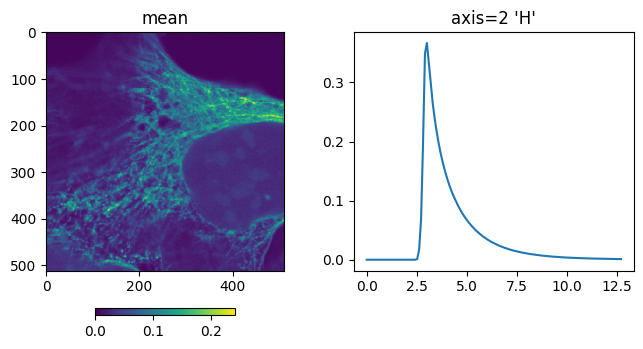

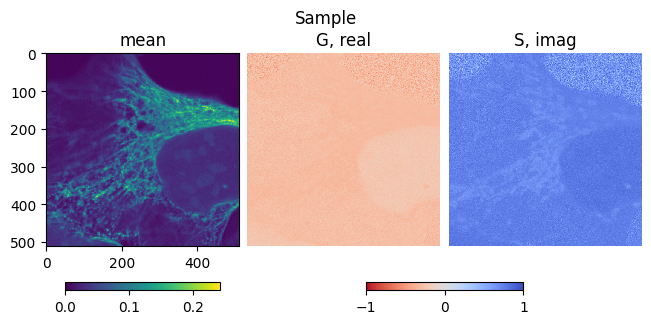

(512, 512)
(512, 512)
(512, 512)


In [ ]:
plot_signal_image(signal, axis='H')
mean, real, imag = phasor_from_signal(signal, axis='H')
plot_phasor_image(mean, real, imag, title='Sample')
print(mean.shape)
print(real.shape)
print(imag.shape)

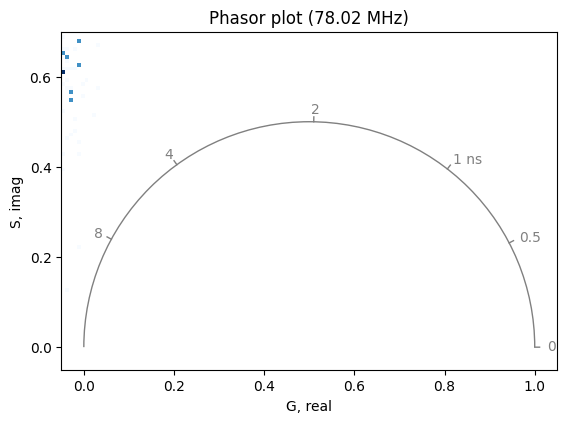

In [ ]:
#from phasorpy.plot import plot_phasor
#import numpy
plot_phasor(
    real,
    imag,
    frequency=frequency,
    #cmin=10,
    #title=f'{filename} ({frequency} MHz)',
)

## Load a TD-FLIM reference signal,  a homogeneous solution of Atto 488 with a lifetime of 4.1 ns.

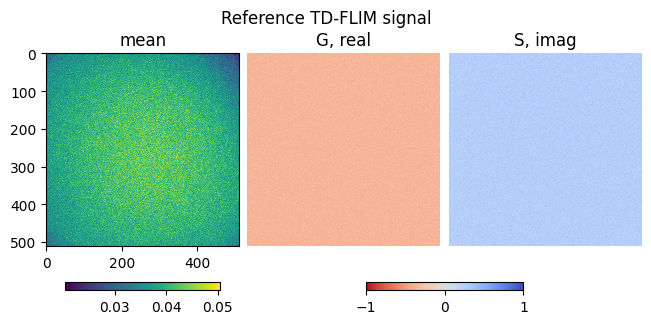

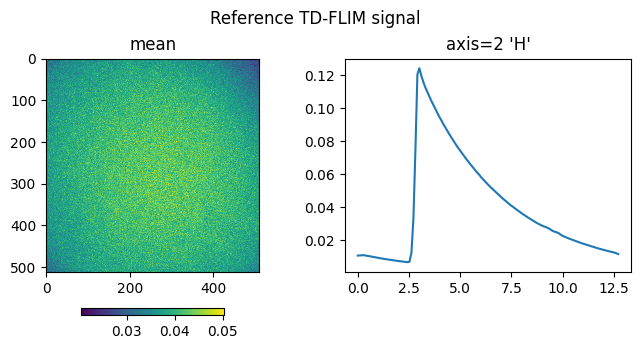

In [ ]:
reference_lifetime = 4.1

img_reference_signal = ref_signal
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)

plot_phasor_image(
    img_reference_mean, img_reference_real, img_reference_imag, title='Reference TD-FLIM signal'
)

plot_signal_image(img_reference_signal, title='Reference TD-FLIM signal')

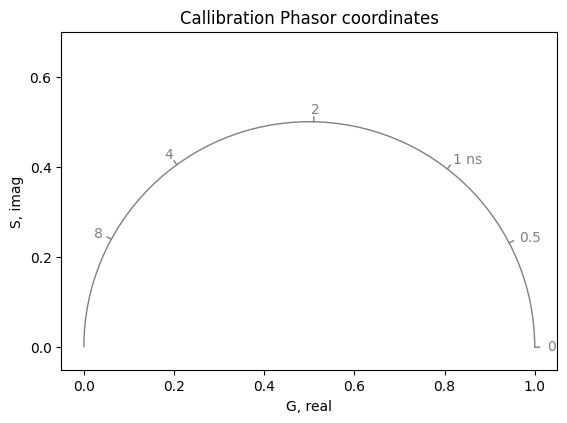

In [ ]:
# Plot calibration phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Callibration Phasor coordinates')
  plot.plot(img_reference_real, img_reference_imag, color = 'b')
  plot.show()

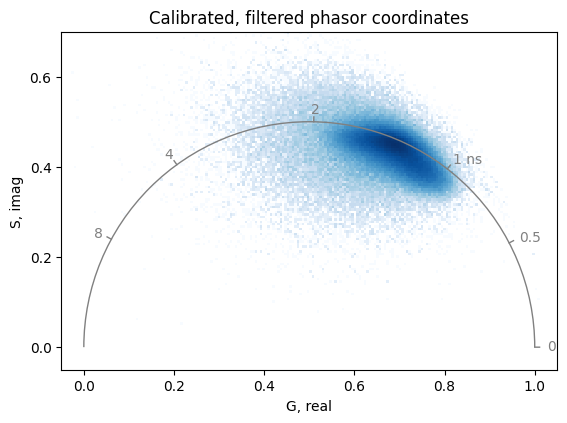

In [ ]:
# Calibrate phasor coordinates using reference
real_cal, imag_cal = phasor_calibrate(real, imag, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_cal, imag_cal, bins = n_bin)


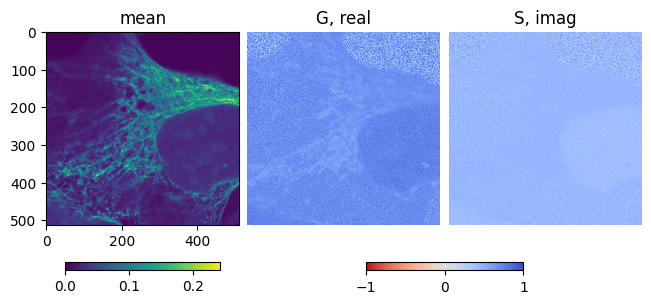

(512, 512)
(512, 512)
(512, 512)


In [ ]:
plot_phasor_image(mean, real_cal, imag_cal)
print(mean.shape)
print(real_cal.shape)
print(imag_cal.shape)

## Filter and threshold

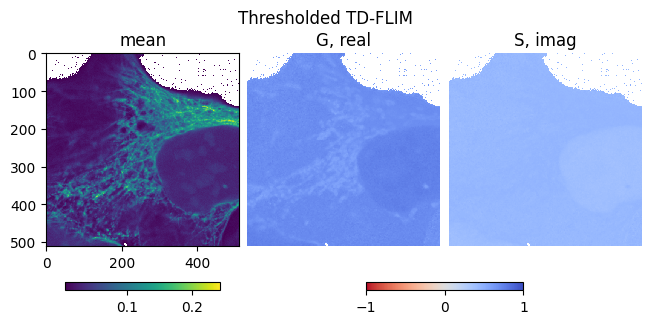

(512, 512)
(512, 512)
(512, 512)


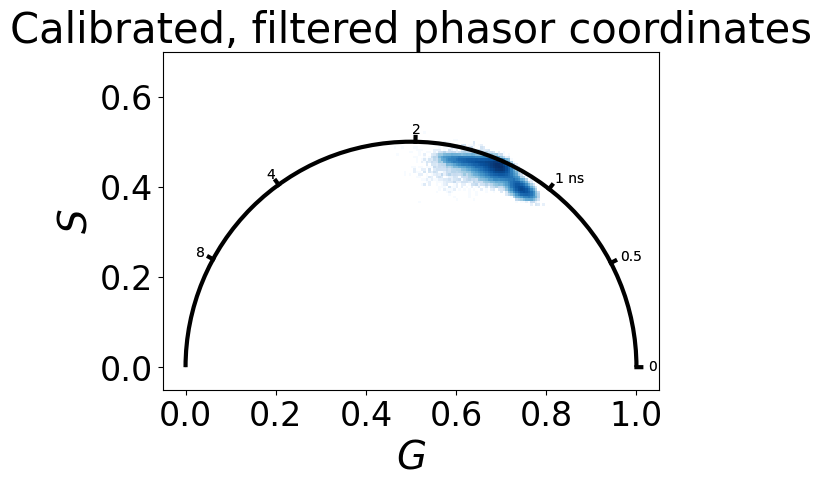

In [ ]:
mean_mf, real_mf, imag_mf = phasor_filter_median(mean, real_cal, imag_cal, size=3, repeat=2)

mean_th, real_th, imag_th = phasor_threshold(mean_mf, real_mf, imag_mf, mean_min=0.0052)
plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')
phasorplot = PhasorPlot(frequency=frequency)
phasorplot.hist2d(real_th, imag_th, bins = n_bin)
phasorplot.semicircle(frequency, linewidth= lw, color = sc_color)

#Formatting
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Calibrated, filtered phasor coordinates', fontsize = fontsize)

print(mean_th.shape)
print(real_th.shape)
print(imag_th.shape)

## Zoom to phasor plot

Text(0.5, 1.0, 'Calibrated,\nfiltered phasor coordinates')

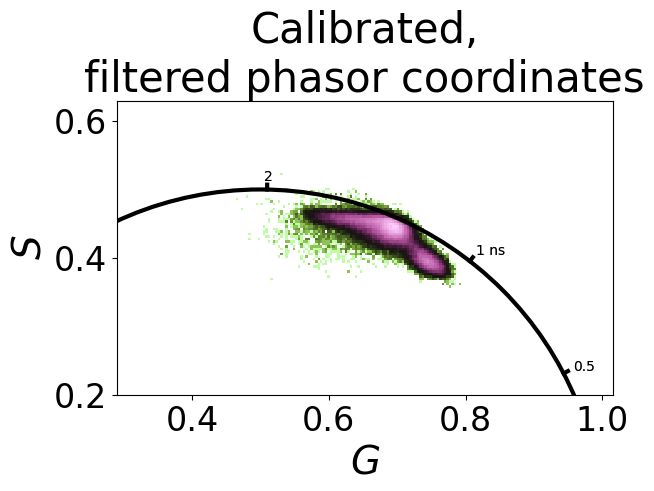

In [ ]:
phasorplot = PhasorPlot( xlim=xlim, ylim=ylim,frequency=frequency)
phasorplot.hist2d(real_th, imag_th, bins = n_bin, cmap= cmap_ph)
phasorplot.semicircle(frequency, linewidth= lw, color = sc_color)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Calibrated,\nfiltered phasor coordinates', fontsize = fontsize)

## Cursor analysis

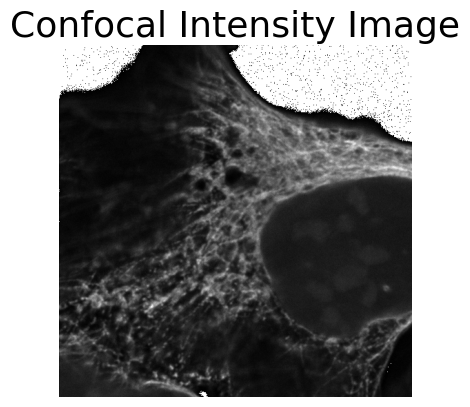

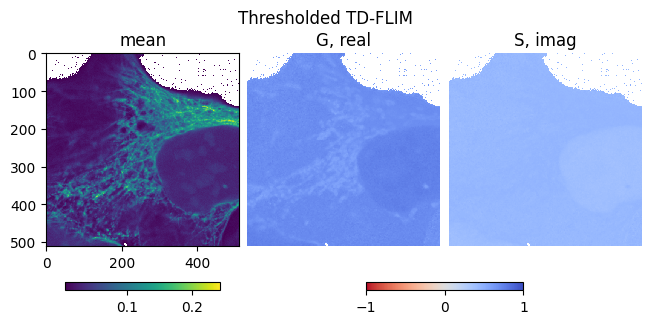

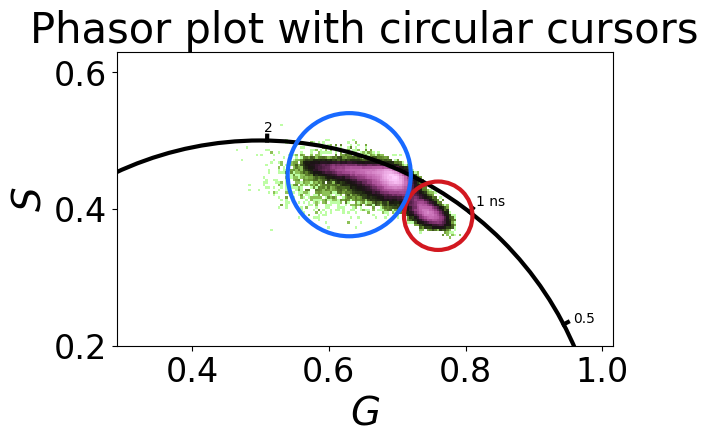

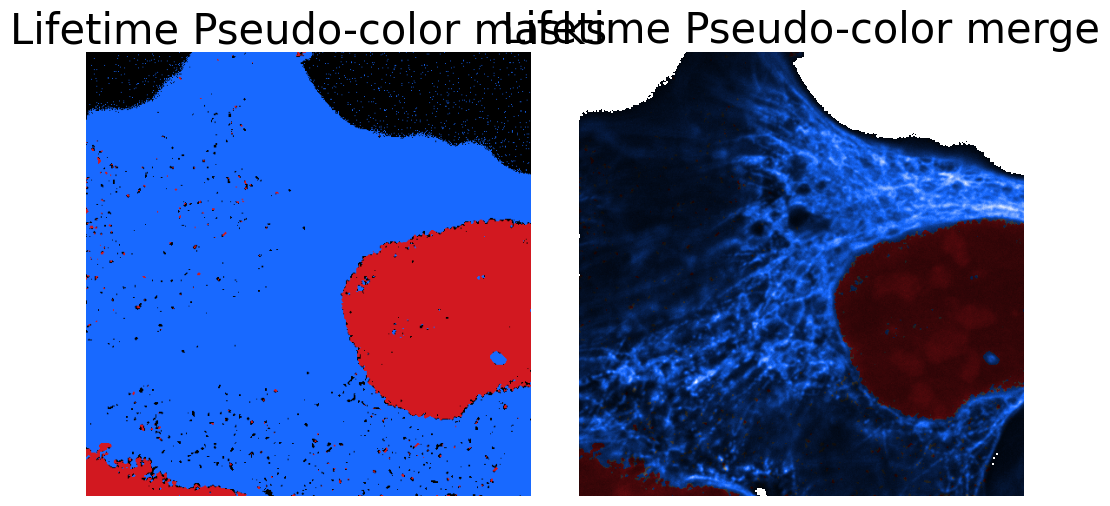

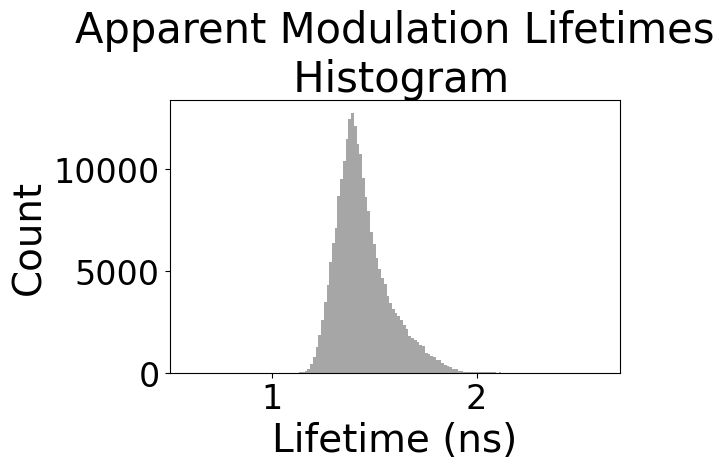

In [ ]:
#lw = 3
#image = mean_th
#gmap = real_th
#smap = imag_th

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mean_th, cmap= intensity)
plt.title("Confocal Intensity Image", fontsize = fontsize -4)
plt.axis('off')

# Assigning cursors
cursors_real = [0.76, 0.63]
cursors_imag = [0.39, 0.45]
radius = [0.05, 0.09]

circular_mask = mask_from_circular_cursor(
    real_th, imag_th, cursors_real, cursors_imag, radius=radius
)

########## Plot

plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Circular cursors')
plot.semicircle(frequency, linewidth= lw, color = sc_color)
plot.hist2d(real_th, imag_th, cmap= cmap_ph, bins = n_bin)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i],
        linestyle='-', linewidth = lw_cursor
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_th, colors=CATEGORICAL[:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 530
y_pos = 470

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th, imag_th, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

## 3 cursor analysis

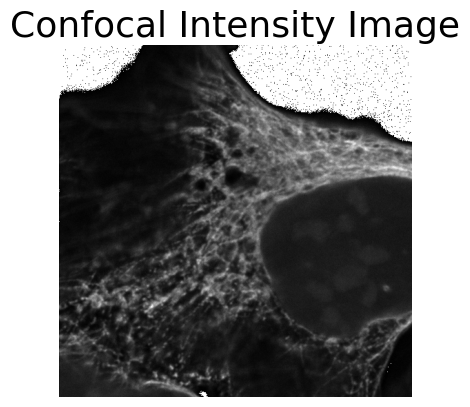

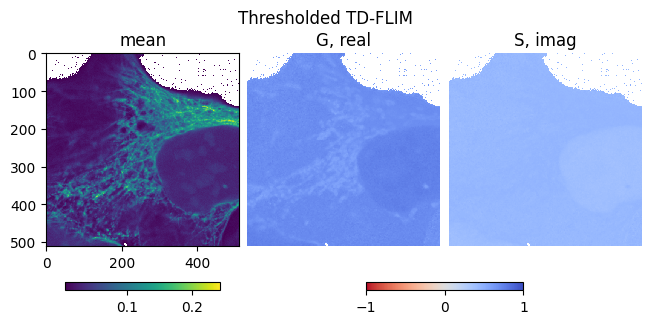

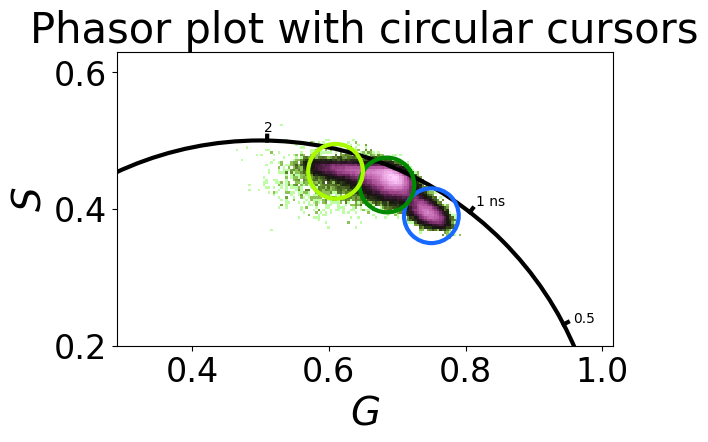

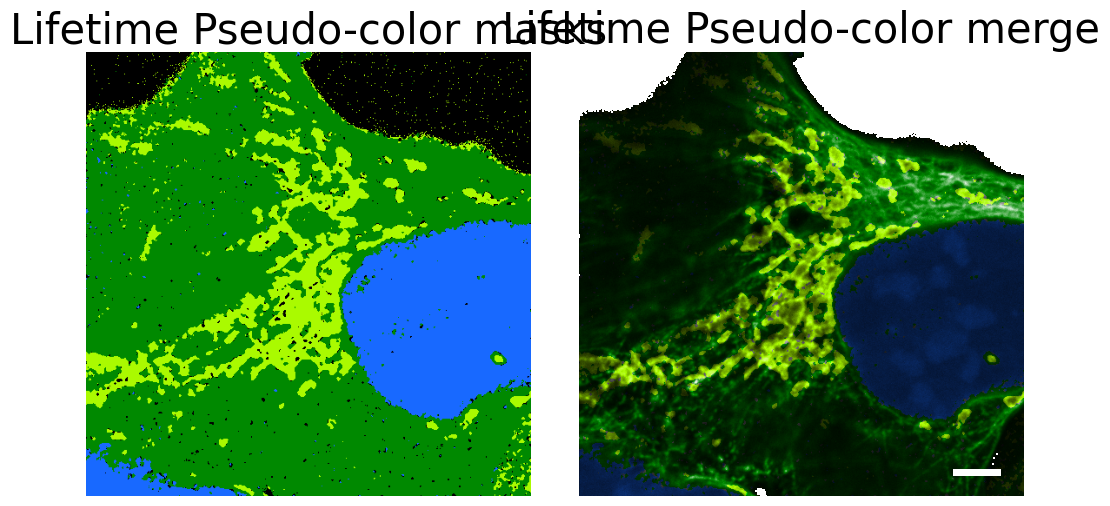

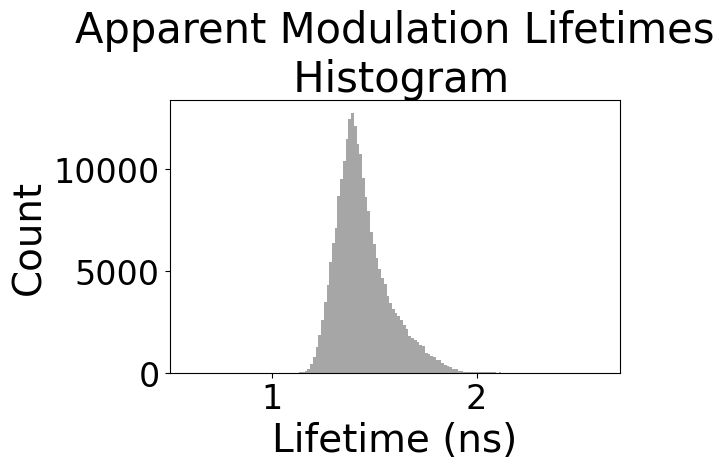

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mean_th, cmap=intensity)
plt.title("Confocal Intensity Image", fontsize = fontsize -4)
plt.axis('off')

# Assigning cursors
# when using i+1 in CATEGORICAL:
#cursor colors   blue, green, pink, purple, yellow, cyan, ora, brown, darkblue
#components     [DAPI, AF555,    NA,   NA, AF532]
cursors_real =  [0.75, 0.685,   0.01, 0.01,  0.61]
cursors_imag =  [0.39, 0.435, 0.01, 0.01,  0.455]
radius       =  [0.04, 0.04,   0.01, 0.01,  0.04]

circular_mask = mask_from_circular_cursor(
    real_th, imag_th, cursors_real, cursors_imag, radius=radius
)

########## Plot

plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Circular cursors')
plot.semicircle(frequency=frequency, linewidth= lw, color = sc_color)
plot.hist2d(real_th, imag_th, cmap=cmap_ph, bins = n_bin)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_th, colors=CATEGORICAL[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels (4.4um)
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 430
y_pos = 480

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th, imag_th, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

## Component Analysis

In [ ]:
import math

from phasorpy.component import (
    phasor_component_fit,
    phasor_component_fraction,
    phasor_component_graphical,
)

np.random.seed(42)
component_style = {
    'linestyle': '-',
    'linewidth': lw_plot,
    'marker': 'o',
    'color': tag_color,
    'fontsize': 20,
}

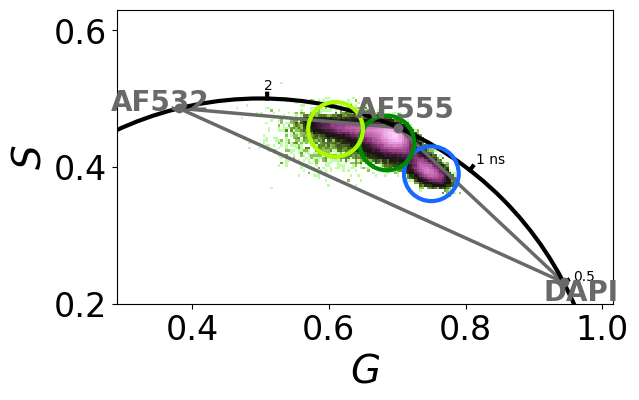

In [ ]:
#                     [DAPI, AF555, AF532]
component_lifetimes = [ 0.5,   1.33,   2.6]
component_real, component_imag = phasor_from_lifetime(
    frequency, component_lifetimes
)

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_th, colors=CATEGORICAL[1:])

## Plotting

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False)
plot.semicircle(frequency=frequency, linewidth= lw, color = sc_color)

plot.hist2d(real_th, imag_th, cmap = cmap_ph, bins = n_bin)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor
    )
#plot.contour(real_th, imag_th, bins=150, levels= 10, cmap=cmap_c, norm='log')
plot.components(
    component_real, component_imag, labels=['DAPI', 'AF555', 'AF532'], **component_style
)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('', fontsize = fontsize)
plot.show()

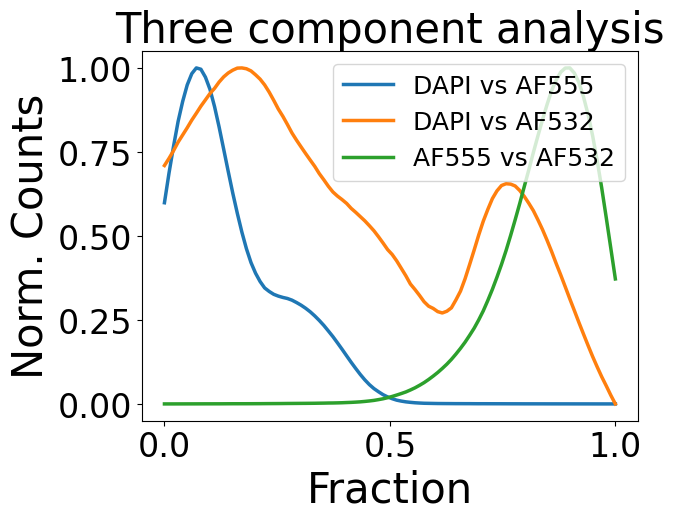

In [ ]:
#counts[0] is DAPI  vs  AF555
#counts[1] is DAPI  vs  AF532
#counts[2] is AF555 vs  AF532

rad = 0.013                           # Cursor size for the multicomponent analysis

fractions = np.linspace(0.0, 1.0, 100)

counts = phasor_component_graphical(
    real_th,
    imag_th,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
)

#Min-max normalization

normcounts_0 = (counts[0] - np.min(counts[0])) / (np.max(counts[0]) - np.min(counts[0]))
normcounts_1 = (counts[1] - np.min(counts[1])) / (np.max(counts[1]) - np.min(counts[1]))
normcounts_2 = (counts[2] - np.min(counts[2])) / (np.max(counts[2]) - np.min(counts[2]))

fig, ax = plt.subplots()

ax.plot(fractions, normcounts_0, '-', label='DAPI vs AF555', linewidth = lw_plot)
ax.plot(fractions, normcounts_1, '-', label='DAPI vs AF532', linewidth = lw_plot)
ax.plot(fractions, normcounts_2, '-', label='AF555 vs AF532', linewidth = lw_plot)
ax.set_title('Three component analysis', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = fontsize)
ax.set_ylabel('Norm. Counts', fontsize = fontsize)
ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.legend(fontsize = legendsize)
plt.show()

## Sharpen the image with MSSR

progress: 100%|██████████| 9/9 [00:00<00:00, 18.48it/s]


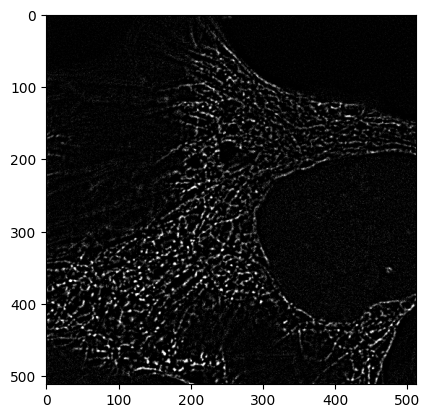

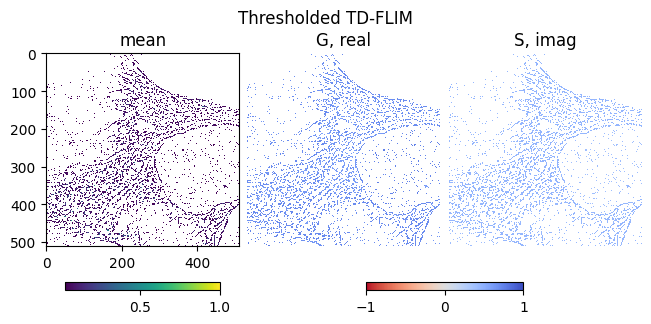

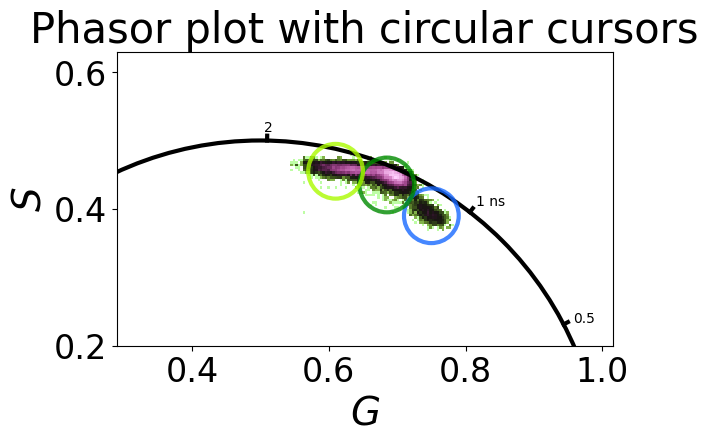

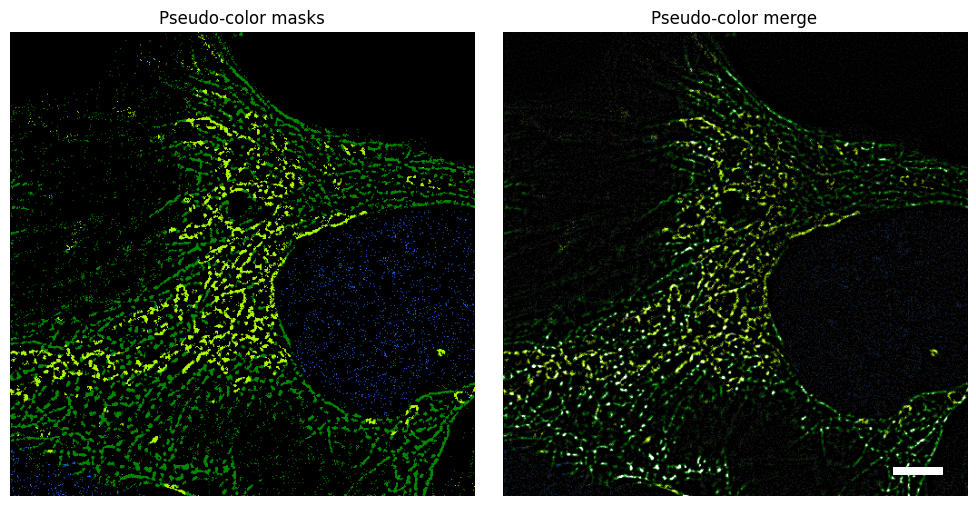

In [ ]:
# Parameter for MSSR
#pixel size = 79nm
sigma_px = 3.44

#fwhm = 3.44              #calculated with the 'Compute FWHM of PSF' function in the MSSR plugin for ImageJ
fwhm = 2.35 * sigma_px  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True

#Apply MSSR1
mean_mssr1 = mssr_instance.sfMSSR(mean, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
plt.imshow(mean_mssr1, cmap='gray', vmin=0, vmax=0.25)

## Threshold
mean_th_mssr1, real_th_mssr1, imag_th_mssr1 = phasor_threshold(mean_mssr1, real_mf, imag_mf, mean_min=0.03)

#Circular cursor masking
circular_mask = mask_from_circular_cursor(
    real_th_mssr1, imag_th_mssr1, cursors_real, cursors_imag, radius=radius  #the cursor coordinates are defined above
)

#Plotting

plot_phasor_image(mean_th_mssr1, real_th_mssr1, imag_th_mssr1, title='Thresholded TD-FLIM')

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Circular cursors')
plot.semicircle(frequency=frequency, linewidth= lw, color = sc_color)
plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap=cmap_ph, bins = n_bin)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor, alpha =0.8
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_mssr1, colors=CATEGORICAL[1:], vmin=0, vmax=0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

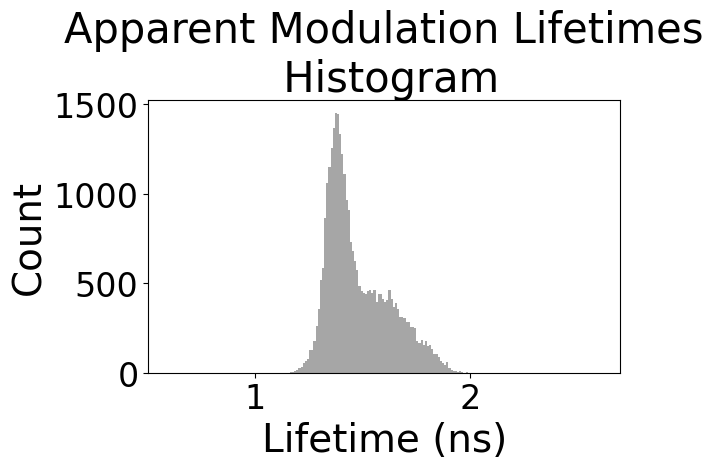

In [ ]:
#### Histograms

phase_lt_mssr, mod_lt_mssr = phasor_to_apparent_lifetime(
    real_th_mssr1, imag_th_mssr1, frequency
)

plot_histograms(
    mod_lt_mssr,
    range=(0.6, 2.6),
    bins=200,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize,
    )

## Component Analysis

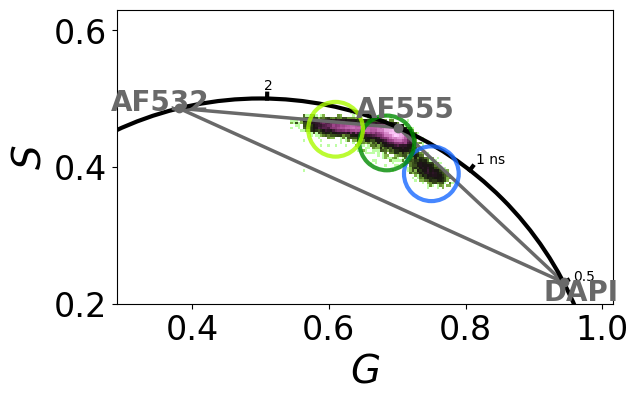

In [ ]:
#                     [DAPI, AF555, AF532]
component_lifetimes = [0.5,  1.33, 2.6]
component_real, component_imag = phasor_from_lifetime(
    frequency, component_lifetimes
)

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False)
plot.semicircle(frequency=frequency, linewidth= lw, color = sc_color)

plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap=cmap_ph, bins = n_bin)
#plot.contour(real_th, imag_th, bins=150, levesl = 10, cmap='cmc.broc_r', norm='log')

for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor, alpha = 0.8
    )
plot.components(
    component_real, component_imag, labels=['DAPI', 'AF555', 'AF532'], **component_style
)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('', fontsize = fontsize)
plot.show()

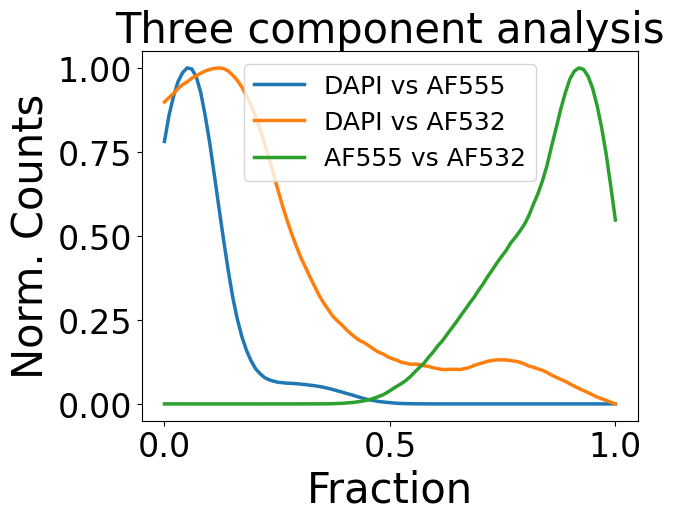

In [ ]:
counts = phasor_component_graphical(
    real_th_mssr1,
    imag_th_mssr1,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
)

#Min-max normalization

normcountsmssr_0 = (counts[0] - np.min(counts[0])) / (np.max(counts[0]) - np.min(counts[0]))
normcountsmssr_1 = (counts[1] - np.min(counts[1])) / (np.max(counts[1]) - np.min(counts[1]))
normcountsmssr_2 = (counts[2] - np.min(counts[2])) / (np.max(counts[2]) - np.min(counts[2]))

fig, ax = plt.subplots()

ax.plot(fractions, normcountsmssr_0, '-', label='DAPI vs AF555', linewidth = lw_plot)
ax.plot(fractions, normcountsmssr_1, '-', label='DAPI vs AF532', linewidth = lw_plot)
ax.plot(fractions, normcountsmssr_2, '-', label='AF555 vs AF532', linewidth = lw_plot)
ax.set_title('Three component analysis', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = fontsize)
ax.set_ylabel('Norm. Counts', fontsize = fontsize)
ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.legend(fontsize = legendsize)
plt.show()

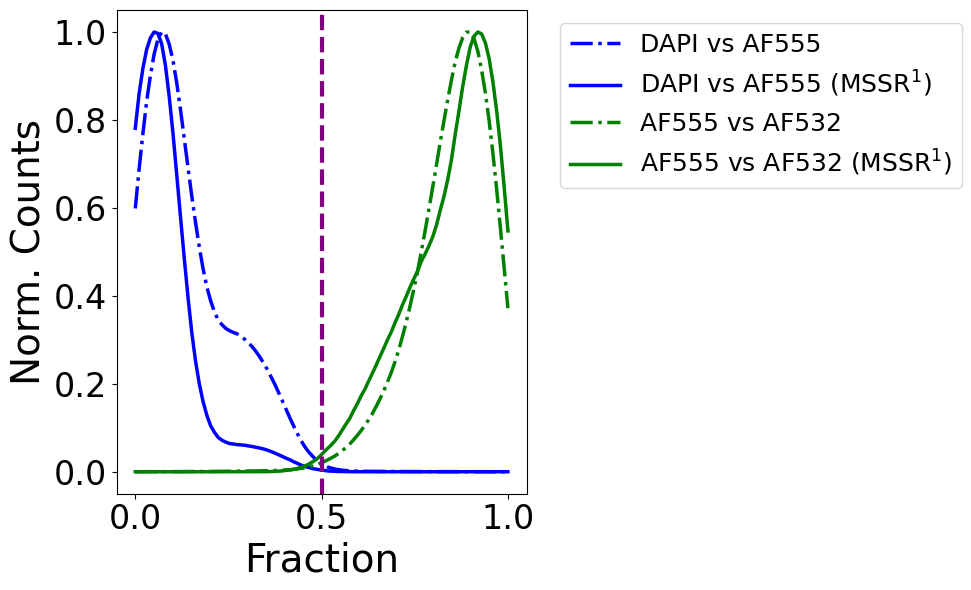

In [ ]:
#counts[0] is DAPI  vs  AF555
#counts[1] is DAPI  vs  AF532
#counts[2] is AF555 vs  AF532

#Figure

fig, ax = plt.subplots(figsize=(10, 6)) # Increased figure size

# DAPI vs AF555
ax.plot(fractions, normcounts_0, label='DAPI vs AF555', linewidth = lw_plot, linestyle = 'dashdot', color = 'b')
ax.plot(fractions, normcountsmssr_0, label='DAPI vs AF555 (MSSR$^1$)', linewidth = lw_plot, color = 'b')

#DAPI vs AF532
#ax.plot(fractions, normcounts_1, label='DAPI vs AF532', linewidth = lw_plot, linestyle = 'dashdot', color = 'y')
#ax.plot(fractions, normcountsmssr_1, label='DAPI vs AF532 (MSSR$^1$)', linewidth = lw_plot, color = 'y')

#AF555 vs AF532
ax.plot(fractions, normcounts_2, label='AF555 vs AF532', linewidth = lw_plot, linestyle = 'dashdot', color = 'g')
ax.plot(fractions, normcountsmssr_2, label='AF555 vs AF532 (MSSR$^1$)', linewidth = lw_plot, color = 'g')

#Figure setup
#ax.set_title('Three component analysis', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Counts', fontsize = labelsize)

ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = lw, color = 'purple')

ax.legend(fontsize = legendsize, bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.tight_layout() # Adjust layout to prevent legend overlap
plt.show()

In [ ]:
G_before = real_th
S_before = imag_th
G_after = real_th_mssr1
S_after = imag_th_mssr1


#normcounts_0 = DAPI vs AF555
#normcounts_1 = DAPI vs AF532
#normcounts_2 = AF555 vs AF532

before = normcounts_1
after = normcountsmssr_1

# --- Run the phasor metrics function --- #
phasor_metrics = compute_phasor_metrics(G_before, S_before, G_after, S_after)

# --- Run the fraction metrics function ---#

fraction_metrics = compute_fraction_metrics(fractions, before, after)


--- Phasor Metrics ---
n_points_before          : 231482
n_points_after           : 31461
centroid_before          : (0.6889, 0.4363)
centroid_after           : (0.6735, 0.4485)
centroid_displacement    :  0.0196
ellipse_area_before      :  0.0104
ellipse_area_after       :  0.0086
area_ratio               :  0.8259
anisotropy_before        :  3.3074
anisotropy_after         :  3.6173
anisotropy_ratio         :  1.0937
covariance_before        : [[ 0.00149012 -0.00066385]
 [-0.00066385  0.00049965]]
covariance_after         : [[ 0.00153142 -0.00040265]
 [-0.00040265  0.0002412 ]]
sigma_GS_before          : -0.0007
sigma_GS_after           : -0.0004
orientation_before_deg   : -26.6385
orientation_after_deg    : -15.9853
orientation_change_deg   :  10.6532

--- Fraction Metrics ---
variance_before     :  2.001878e-05
variance_after      :  9.783088e-05
overlap_coefficient :  7.322877e-01
JSD                 :  4.592161e-02
f_star_before       :  8.888889e-01
f_star_after        :  2.424

## Analysis of ROIs ##

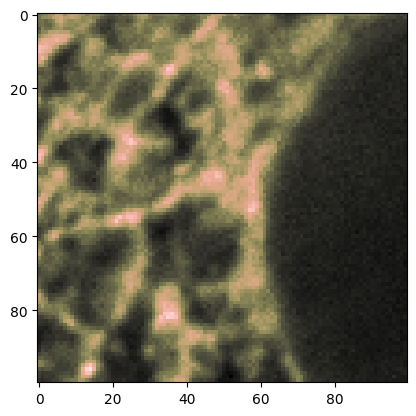

In [ ]:
# ----- ROIs selection ----- #

#ROI1 rows: 165:265 , columns: 305:405
#ROI2 rows: 190:290 , columns: 220:320
#ROI3 rows: 340:440 , columns: 385:485
#ROI4 rows: 300:400 , columns: 230:330

roi1_mean_th = mean_th[165:265, 305:405]           # Intensity image
roi1_real_th = real_th[165:265, 305:405]           # G map
roi1_imag_th = imag_th[165:265, 305:405]           # S map

roi2_mean_th = mean_th[230:330, 230:330]           # Intensity image
roi2_real_th = real_th[230:330, 230:330]           # G map
roi2_imag_th = imag_th[230:330, 230:330]           # S map

roi3_mean_th = mean_th[340:440, 385:485]           # Intensity image
roi3_real_th = real_th[340:440, 385:485]           # G map
roi3_imag_th = imag_th[340:440, 385:485]           # S map

roi4_mean_th = mean_th[300:400, 230:330]           # Intensity image
roi4_real_th = real_th[300:400, 230:330]           # G map
roi4_imag_th = imag_th[300:400, 230:330]           # S map

plt.imshow(roi2_mean_th, cmap = 'cmc.turku')    # Uncomment to see the ROI selected
#print(roi4_mean_th.shape)

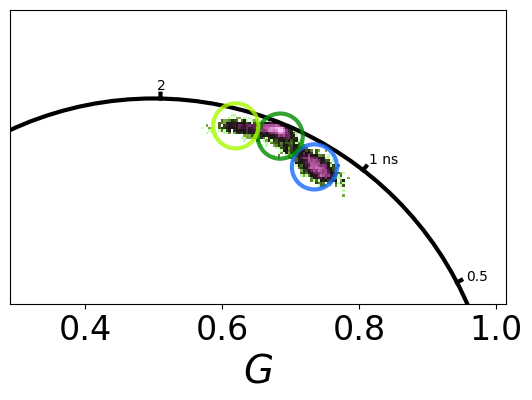

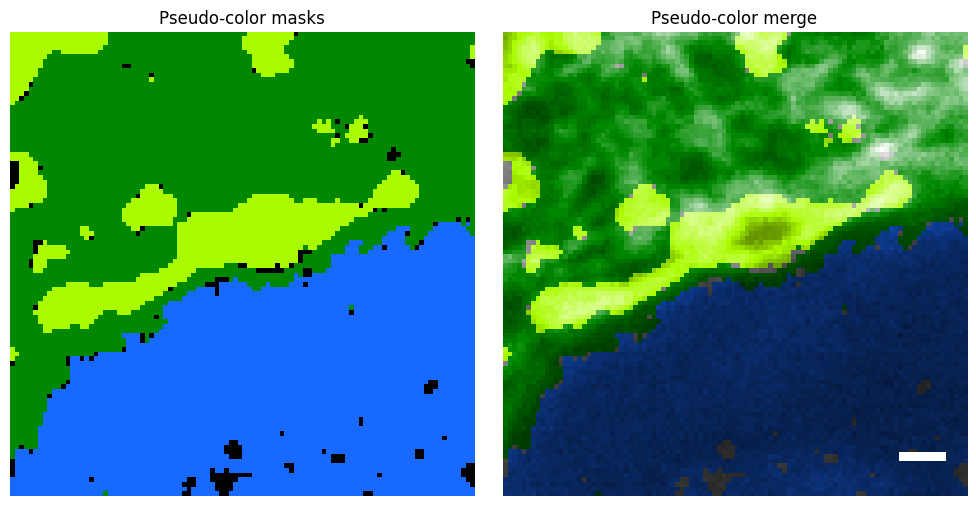

In [ ]:
# ----- Phasors form ROIs ----- #

roi = 1
mean_th_zoom = roi1_mean_th  #change the name of the roi to be used, e.g for the roi1 use roi1_...
real_th_zoom = roi1_real_th
imag_th_zoom = roi1_imag_th
intensity = mean_th_zoom

#Cursors for
#ROI1_real [0.735, 0.685, 0.01,0.01, 0.62]
#ROI1_imag [0.4, 0.445, 0.01, 0.01, 0.46]
#ROI1_radii [0.033, 0.033, 0.01, 0.01, 0.033]
#ROI2_real [0.73, 0.675, 0.01,  0.01,  0.605]
#ROI2_imag [0.405, 0.445, 0.01,  0.01,  0.46]
#ROI2_radii [0.035, 0.035, 0.01,  0.01, 0.035]
#ROI3_real [0.75, 0.69, 0.01,  0.01,  0.615]
#ROI3_imag [0.39, 0.44, 0.01,  0.01,  0.455]
#ROI3_radii [0.04, 0.04, 0.01,  0.01, 0.04]
#ROI4_real [0.75, 0.69, 0.01,  0.01,  0.615]
#ROI4_imag [0.39, 0.44, 0.01,  0.01,  0.455]
#ROI4_radii [0.04, 0.04, 0.01,  0.01, 0.04]

#Parameters for scale bar (Change according to the size of the image analyzed)
scalebar_width = 10  # in pixels (79nm/px)
scalebar_height = 2

# Position: bottom left with a 10-pixel margin
x_pos = 85
y_pos = 90
bar_color = 'white'  # or 'black' depending on your image

#components     [DAPI, AF555,    NA,   NA, AF532]
#cursor colors  blue, green, pink, purple, yellow, cyan, ora, brown, darkblue
cursors_real_roi = [0.735, 0.685, 0.01,0.01, 0.62]    #Write 0.01 in position of purple to skip that color
cursors_imag_roi = [0.4, 0.445, 0.01, 0.01, 0.46]
radius_roi =       [0.033, 0.033, 0.01, 0.01, 0.033]

circular_mask = mask_from_circular_cursor(
    real_th_zoom, imag_th_zoom, cursors_real_roi, cursors_imag_roi, radius=radius_roi
)


plot = PhasorPlot(xlim = xlim, ylim = ylim, allquadrants=False, title='Phasor plot')
plot.semicircle(frequency, linewidth= lw  ,color = sc_color)                 #To change the visibility of the semicircle
plot.hist2d(real_th_zoom, imag_th_zoom, cmap=cmap_ph, bins = n_bin)

for i in range(len(cursors_real_roi)):
    plot.cursor(
        cursors_real_roi[i],
        cursors_imag_roi[i],
        radius=radius_roi[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor, alpha = 0.8
    )

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize)
plot.ax.yaxis.set_visible(False)
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = intensity, colors=CATEGORICAL[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height, linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

### Sharpen ROIs with MSSR ###

progress: 100%|██████████| 9/9 [00:00<00:00, 536.36it/s]


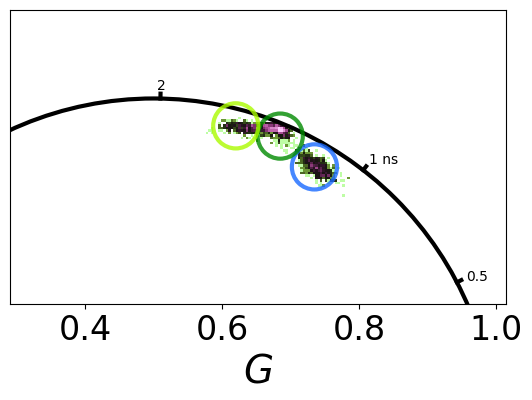

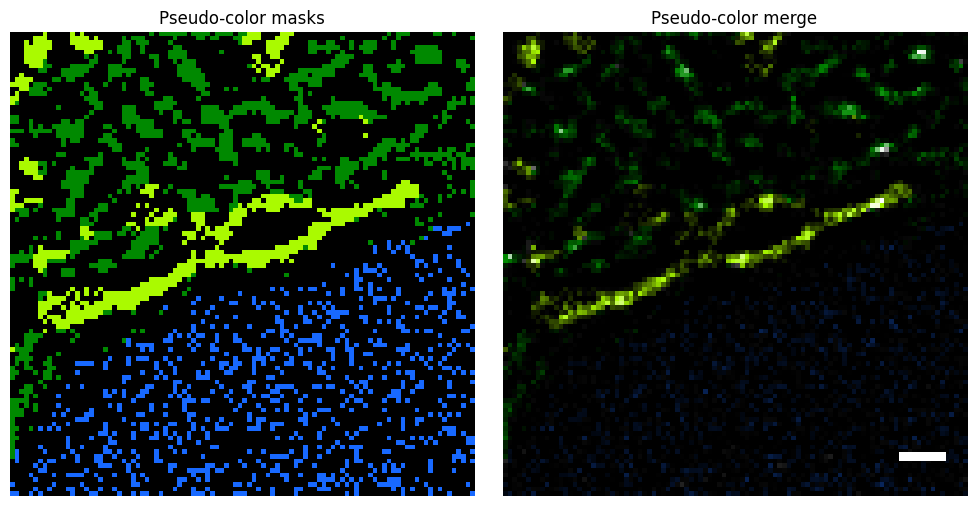

In [ ]:
#Apply MSSR1

mean_zoom_mssr = mssr_instance.sfMSSR(mean_th_zoom, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
intensity_roi = mean_zoom_mssr

#plt.imshow(mean_zoom_mssr, cmap='cmc.turku')  # Uncomment to see the ROI selected

#Parameters for scale bar (Change according to the size of the image analyzed)

scalebar_width = 10  # in pixels  (79nm per pixel)
scalebar_height = 2
# Position: bottom left with a 10-pixel margin
x_pos = 85
y_pos = 90
bar_color = 'white'  # or 'black' depending on your image

## Threshold
mean_th_zoom_mssr, real_th_zoom_mssr, imag_th_zoom_mssr = phasor_threshold(mean_zoom_mssr, real_th_zoom, imag_th_zoom, mean_min=0.03)

## Masks from phasors

circular_mask = mask_from_circular_cursor(
    real_th_zoom_mssr, imag_th_zoom_mssr, cursors_real_roi, cursors_imag_roi, radius=radius_roi
)


plot = PhasorPlot(xlim = xlim, ylim=ylim, allquadrants=False, title='Phasor plot')
plot.semicircle(frequency=frequency, linewidth= lw, color = sc_color)
plot.hist2d(real_th_zoom_mssr, imag_th_zoom_mssr, cmap=cmap_ph, bins= n_bin)

for i in range(len(cursors_real_roi)):
    plot.cursor(
        cursors_real_roi[i],
        cursors_imag_roi[i],
        radius=radius_roi[i],
        #crosshair=True,
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor, alpha = 0.8
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize) #Phasor plot with circular cursors
plot.ax.yaxis.set_visible(False)
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = intensity_roi, colors=CATEGORICAL[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()


### 3 Component Analysis of ROIs ###

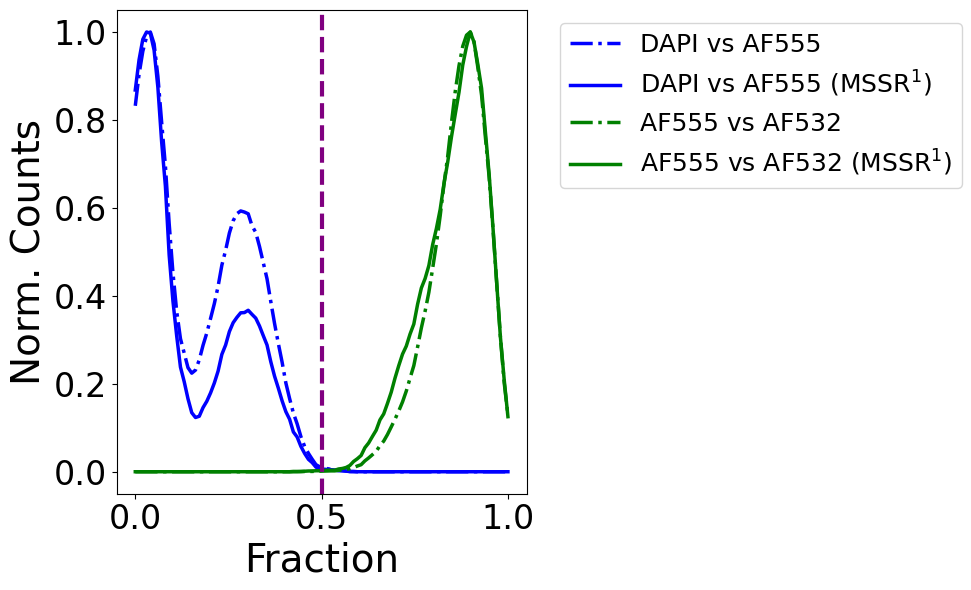

In [ ]:
#counts[0] is DAPI  vs  AF555
#counts[1] is DAPI  vs  AF532
#counts[2] is AF555 vs  AF532

rad = 0.01                           # Cursor size for the multicomponent analysis
fractions = np.linspace(0.0, 1.0, 100)

# ----- 3-Component Analysis before MSSR ----- #

countszm = phasor_component_graphical(
    real_th_zoom,
    imag_th_zoom,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
)

#Min-max normalization

normcountszm_0 = (countszm[0] - np.min(countszm[0])) / (np.max(countszm[0]) - np.min(countszm[0]))
normcountszm_1 = (countszm[1] - np.min(countszm[1])) / (np.max(countszm[1]) - np.min(countszm[1]))
normcountszm_2 = (countszm[2] - np.min(countszm[2])) / (np.max(countszm[2]) - np.min(countszm[2]))

#fig, ax = plt.subplots()
#ax.plot(fractions, normcountszm_0, '-', label='DAPI vs AF555', linewidth = lw_plot)
#ax.plot(fractions, normcountszm_1, '-', label='DAPI vs AF532', linewidth = lw_plot)
#ax.plot(fractions, normcountszm_2, '-', label='AF555 vs AF532', linewidth = lw_plot)
#ax.set_title('Three component analysis', fontsize = fontsize)
#ax.set_xlabel('Fraction', fontsize = fontsize)
#ax.set_ylabel('Norm. Counts', fontsize = fontsize)
#ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
#ax.legend(fontsize = legendsize)
#plt.show()

# ----- 3-Component Analysis after MSSR ----- #

countszmmssr = phasor_component_graphical(
    real_th_zoom_mssr,
    imag_th_zoom_mssr,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
)

#Min-max normalization

normcountszmmssr_0 = (countszmmssr[0] - np.min(countszmmssr[0])) / (np.max(countszmmssr[0]) - np.min(countszmmssr[0]))
normcountszmmssr_1 = (countszmmssr[1] - np.min(countszmmssr[1])) / (np.max(countszmmssr[1]) - np.min(countszmmssr[1]))
normcountszmmssr_2 = (countszmmssr[2] - np.min(countszmmssr[2])) / (np.max(countszmmssr[2]) - np.min(countszmmssr[2]))

#fig, ax = plt.subplots()
#ax.plot(fractions, normcountszmmssr_0, '-', label='DAPI vs AF555', linewidth = lw_plot)
#ax.plot(fractions, normcountszmmssr_1, '-', label='DAPI vs AF532', linewidth = lw_plot)
#ax.plot(fractions, normcountszmmssr_2, '-', label='AF555 vs AF532', linewidth = lw_plot)
#ax.set_title('Three component analysis', fontsize = fontsize)
#ax.set_xlabel('Fraction', fontsize = fontsize)
#ax.set_ylabel('Norm. Counts', fontsize = fontsize)
#ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
#ax.legend(fontsize = legendsize)
#plt.show()

# ----- Before vs After Plots ----- #

#counts[0] is DAPI  vs  AF555
#counts[1] is DAPI  vs  AF532
#counts[2] is AF555 vs  AF532

#Figure

fig, ax = plt.subplots(figsize=(10, 6)) # Increased figure size

# DAPI vs AF555
ax.plot(fractions, normcountszm_0, label='DAPI vs AF555', linewidth = lw_plot, linestyle = 'dashdot', color = 'b')
ax.plot(fractions, normcountszmmssr_0, label='DAPI vs AF555 (MSSR$^1$)', linewidth = lw_plot, color = 'b')

#DAPI vs AF532
#ax.plot(fractions, normcountszm_1, label='DAPI vs AF532', linewidth = lw_plot, linestyle = 'dashdot', color = 'y')
#ax.plot(fractions, normcountszmmssr_1, label='DAPI vs AF532 (MSSR$^1$)', linewidth = lw_plot, color = 'y')

#AF555 vs AF532
ax.plot(fractions, normcountszm_2, label='AF555 vs AF532', linewidth = lw_plot, linestyle = 'dashdot', color = 'g')
ax.plot(fractions, normcountszmmssr_2, label='AF555 vs AF532 (MSSR$^1$)', linewidth = lw_plot, color = 'g')

#Figure setup
#ax.set_title(f'Three component analysis, ROI {roi}', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Counts', fontsize = labelsize)

ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = lw, color = 'purple')

ax.legend(fontsize = legendsize, bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.tight_layout() # Adjust layout to prevent legend overlap
plt.show()

In [ ]:
# ----- Phasor and Fraction Metrics of ROIs ----- #

G_before = real_th_zoom
S_before = imag_th_zoom
G_after = real_th_zoom_mssr
S_after = imag_th_zoom_mssr


#normcounts_0 = DAPI vs AF555
#normcounts_1 = DAPI vs AF532
#normcounts_2 = AF555 vs AF532

before = normcountszm_1
after = normcountszmmssr_1

# --- Run the phasor metrics function --- #
phasor_metrics = compute_phasor_metrics(G_before, S_before, G_after, S_after)

# --- Run the fraction metrics function ---#

fraction_metrics = compute_fraction_metrics(fractions, before, after)


--- Phasor Metrics ---
n_points_before          : 10000
n_points_after           : 2743
centroid_before          : (0.6987, 0.4307)
centroid_after           : (0.6877, 0.4372)
centroid_displacement    :  0.0128
ellipse_area_before      :  0.0092
ellipse_area_after       :  0.0107
area_ratio               :  1.1694
anisotropy_before        :  4.4767
anisotropy_after         :  4.1129
anisotropy_ratio         :  0.9187
covariance_before        : [[ 0.00153528 -0.000962  ]
 [-0.000962    0.00075782]]
covariance_after         : [[ 0.00174644 -0.00098224]
 [-0.00098224  0.00073881]]
sigma_GS_before          : -0.0010
sigma_GS_after           : -0.0010
orientation_before_deg   : -33.9985
orientation_after_deg    : -31.4228
orientation_change_deg   :  2.5758

--- Fraction Metrics ---
variance_before     :  5.070684e-05
variance_after      :  7.231185e-05
overlap_coefficient :  8.999383e-01
JSD                 :  7.276768e-03
f_star_before       :  8.484848e-01
f_star_after        :  2.424242

## Save the intensity image as TIFF

In [ ]:
#from google.colab import files

#image = mean_th

# Save the intensity image as a TIFF file
#output_image_path = "/content/drive/MyDrive/2025/MSSR-FLIM/Data/3CGQ_Intensity_image.tif"
#tifffile.imwrite(output_image_path, image)

# Provide a download link for the saved image
#files.download(output_image_path)

#### Phasor Plot form Custom hist2d function ####

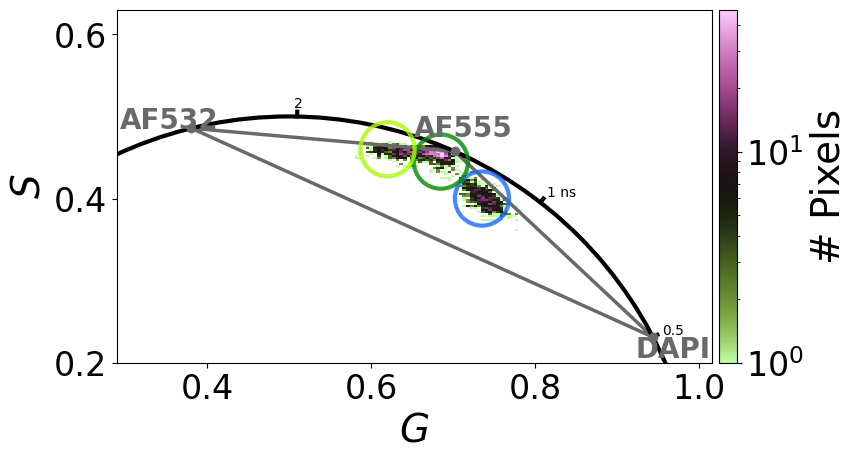

In [ ]:
# Whole cell phasor component maps
# cursor parameters: cursor_real
#                    cursor_imag
#                    radius
# Before MSSR: real_th, imag_th
# After MSSR: real_th_mssr1, imag_th_mssr1

# ROIs' phasor component maps
# cursor parameters: cursor_real_roi
#                    cursor_imag_roi
#                    radius_roi
# Before MSSR: real_th_zoom, imag_th_zoom
# After MSSR: real_th_zoom_mssr, imag_th_zoom_mssr

# Create figure and main axis
fig, ax = plt.subplots(figsize=(8,15))

# Create the phasor plot on this axis
plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, ax=ax)
plot.semicircle(frequency=frequency, linewidth=lw, color=sc_color)

# Plot the 2D histogram and get mappable
mappable = plot.my_hist2d(real_th_zoom_mssr, imag_th_zoom_mssr, cmap=cmap_ph, bins= 45)  #bins for full cel = 75, bins for ROI 1 = 40, bins for ROI 2 = 50

# Add cursors
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real_roi[i],
        cursors_imag_roi[i],
        radius=radius_roi[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth=lw_cursor, alpha=0.8
    )

# Add components
plot.components(
    component_real, component_imag, labels=['DAPI', 'AF555', 'AF532'], **component_style
)

# Axis labels, ticks, title
ax.set_xlabel('$G$', fontsize=labelsize)
ax.set_ylabel('$S$', fontsize=labelsize)
ax.tick_params(axis='both', labelsize=ticksize)
ax.set_title('', fontsize=fontsize)

# === Attach a colorbar with same height as the Phasor Plot ===
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.07)  # size controls width, pad = spacing

# Create colorbar on that axis
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('# Pixels', fontsize=labelsize)
cbar.ax.tick_params(labelsize=ticksize)

ax.set_aspect('equal', adjustable='box')
#plt.tight_layout()
plt.show()